In [1]:
import torch
import torch.nn.functional as F
import torch.nn as nn

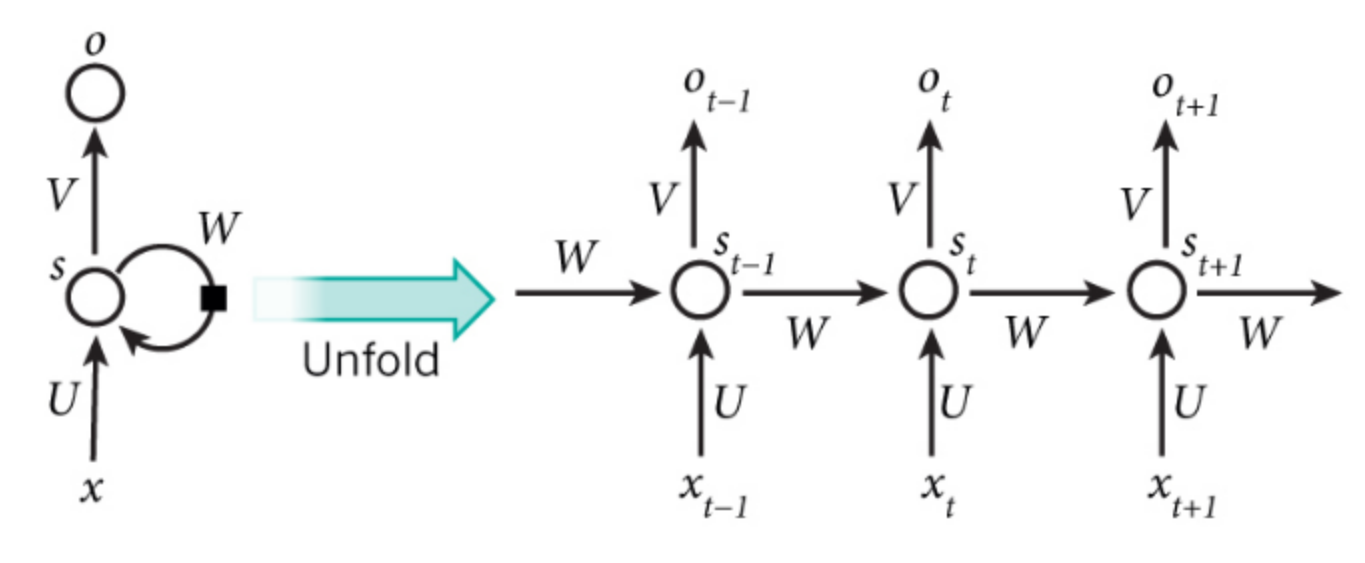

## 使用torch库提供的API构造RNN

In [2]:
# 实例化RNN对象
# 第一个参数: input_size,hidden_size, layer_szie
rnn = nn.RNN(3, 8, 1, batch_first=True) # [B, T, input_size] [T, B, input_size]
# 输入张量x
# 第一个参数  sequenct_length(输入序列的长度)
# 第二个参数 batch_size (批次样本数)
# 第三个参数: input_size(输入张量维度)
input1 = torch.randn(5, 3, 3)
# 设置初始化h0
# 第一个参数 num_layer*num_directions(层数*网络方向数)
# 第二个参数: batch_size 样本数
# 第三个参数: 隐层节点数
h0 = torch.randn(1, 5, 8)
# 输入张量放入RNN.输出结果
output, hn = rnn(input1, h0)
print(output.shape)
# print()

torch.Size([5, 3, 8])


## 基于RNN模型的原理, 定义其中对应的参数W 

In [5]:
class MyRNN(nn.Module):
    def __init__(self, input_size, hidden_size, layers_size,first_batch=False):
        super(MyRNN, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.layers_size = layers_size
        self.first_batch = first_batch

        self.w_in = []
        self.w_hh = []
        self.bh = []

        for layers in range(self.layers_size):
            self.w_in.append(torch.randn([hidden_size, input_size])*0.01)
            self.w_hh.append(torch.randn([hidden_size, hidden_size])*0.01)
            self.bh.append(torch.zeros(hidden_size))
            input_size = hidden_size # 除了第一层，输入与隐层相等
        self.w_in = nn.ParameterList([nn.Parameter(w) for w in self.w_in])
        self.w_hh = nn.ParameterList([nn.Parameter(w) for w in self.w_hh])
        self.bh = nn.ParameterList([nn.Parameter(b) for b in self.bh])

    def forward(self, inputs, hidden=None):
        if self.first_batch:
            batch_size, seq_len, _ = inputs.size()
        else:
            seq_len, batch_size, _ = inputs.size()
            inputs = inputs.transpose(0, 1)

        if hidden is None:
            hidden = [torch.zeros(batch_size, self.hidden_size) for _ in range(self.layers_size)]

        outputs = []
        # print(inputs.shape)
        for t in range(seq_len):
            x = inputs[:, t, :]
            for layer in range(self.layers_size):
                h_pre = hidden[layer]
                h_t = torch.tanh(torch.mm(x, self.w_in[layer].t()) + torch.mm(h_pre, self.w_hh[layer].t()) + self.bh[layer])
                hidden[layer] = h_t
                x = h_t
            outputs.append(h_t.unsqueeze(1))
        outputs = torch.cat(outputs, dim=1)
        if self.first_batch:
            outputs = outputs.transpose(0, 1)
        return outputs, hidden

In [6]:
# 示例：定义参数并运行模型
input_size = 3
hidden_size = 8
num_layers = 1
batch_size = 5
seq_len = 3

# 初始化自定义RNN
model = MyRNN(input_size, hidden_size, num_layers, first_batch=True)

# 生成随机输入
# input_seq = torch.randn(batch_size, seq_len, input_size)
input_seq = torch.randn(seq_len, batch_size, input_size)

# 执行前向传播
output, hidden = model(input_seq)

print(f"输入的数据形状: {input_seq.shape}")
print("输出维度:", output.shape)
print("输出:", output.shape)

输入的数据形状: torch.Size([3, 5, 3])
输出维度: torch.Size([5, 3, 8])
输出: torch.Size([5, 3, 8])
